# X-Wing Team

Integrantes:

* Jorge Díaz
* Hugo Sepúlveda

## Objetivo: Se quiere predecir la cantidad de lesiones y violaciones a los DDHH, por tipo y por sector geográfico.

El dataset a analizar contiene 31 atributos, será solo de Chile, con un rango de fechas ente el 1/enero/2018 y 31/diciembre/2020.

**Dataset**: https://acleddata.com/ (Chile), para descargarlo, entrar al github o solicitarlo en esta página, creando un usuario.

Se intentará predecir a través de regresión, lesiones y violaciones a los DDHH en Chile, considerando 29 atributos para ello, y dejando para predecir la región y tipo (en conjunto, como problema multioutput).

El procedimiento será el siguiente:

* Análisis exploratorio
* Selección y regularización de atributos
* Estandarización y escala
* Modelos:
  * Red Neuronal Feed-Forward
  * Random Forest
  * AdaBoost
  * DecisionTree (validación)

Se ocupa un modelo de referencia para validar a los demás, donde será un árbo de decisión con la máxima profundiad posible.

Para cada modelo, se seleccionaron los mejores hiperparámetros según CV de 10 a través de GridSearchCV. todos los modelos fueorn evaluados con MSE.







## Importar bibliotecas

In [ ]:
import pandas as pd
import numpy as np
from numpy.random import seed

# sklearn
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, Normalizer, MinMaxScaler, normalize, scale, LabelEncoder, OrdinalEncoder, OneHotEncoder
from sklearn.feature_selection import mutual_info_regression, f_regression, SelectKBest
from sklearn.model_selection import GridSearchCV
from sklearn.tree import DecisionTreeRegressor
from sklearn.multioutput import MultiOutputRegressor

# matplotlib, seaborn
import matplotlib.pyplot as plt
import seaborn as sns; sns.set()

# tensorflow
import tensorflow as tf
from tensorflow import convert_to_tensor

# warnings
import warnings
warnings.filterwarnings("ignore")

# keras
from keras.models import Sequential
from keras.layers import Dense, Activation
from keras.optimizers import SGD, Adam, RMSprop
from keras.wrappers.scikit_learn import KerasRegressor
from keras.utils import to_categorical

# Counter
from collections import Counter

# seed
seed(1)
tf.random.set_seed(2)

## Carga dataset

In [ ]:
data = pd.read_csv('sample_data/chile.csv')
print(data.columns)
print(data.shape)
data

Index(['data_id', 'iso', 'event_id_cnty', 'event_id_no_cnty', 'event_date',
       'year', 'time_precision', 'event_type', 'sub_event_type', 'actor1',
       'assoc_actor_1', 'inter1', 'actor2', 'assoc_actor_2', 'inter2',
       'interaction', 'region', 'country', 'admin1', 'admin2', 'admin3',
       'location', 'latitude', 'longitude', 'geo_precision', 'source',
       'source_scale', 'notes', 'fatalities', 'timestamp', 'iso3'],
      dtype='object')
(6493, 31)


,data_id,iso,event_id_cnty,event_id_no_cnty,event_date,year,time_precision,event_type,sub_event_type,actor1,assoc_actor_1,inter1,actor2,assoc_actor_2,inter2,interaction,region,country,admin1,admin2,admin3,location,latitude,longitude,geo_precision,source,source_scale,notes,fatalities,timestamp,iso3
0,7409167,152,CHI6495,6495,11 December 2020,2020,1,Riots,Violent demonstration,Rioters (Chile),NaN,5,NaN,NaN,0,50,South America,Chile,Biobio,Arauco,Arauco,Mocha Island,-38.3807,-73.9112,1,El Sur; Biobio Chile,Subnational,"On 11 December 2020, in Mocha Island, Biobio r...",0,1607982441,CHL
1,7409168,152,CHI6496,6496,11 December 2020,2020,1,Riots,Violent demonstration,Rioters (Chile),NaN,5,Police Forces of Chile (2018-),Civilians (Chile); Labour Group (Chile),1,15,South America,Chile,Metropolitana,Santiago,Santiago Centro,Santiago,-33.4569,-70.6483,1,Biobio Chile; 24 Horas (Chile),National,"On 11 December 2020, in Santiago, Metropolitan...",0,1607982441,CHL
2,7409513,152,CHI6493,6493,11 December 2020,2020,2,Protests,Peaceful protest,Protesters (Chile),Afro-Chilean Ethnic Group (Chile),6,NaN,NaN,0,60,South America,Chile,Arica y Parinacota,Arica,Arica,Arica,-18.4746,-70.2979,1,La Estrella Arica,Subnational,"Around 11 December 2020, in Arica, Arica y Par...",0,1607982444,CHL
3,7409341,152,CHI6494,6494,11 December 2020,2020,1,Protests,Peaceful protest,Protesters (Chile),NaN,6,NaN,NaN,0,60,South America,Chile,Coquimbo,Elqui,La Serena,La Serena,-29.9045,-71.2489,1,El Dia (Chile),National,"On 11 December 2020, in La Serena, Coquimbo re...",0,1607982442,CHL
4,7409164,152,CHI6488,6488,10 December 2020,2020,1,Strategic developments,Looting/property destruction,Indigenous Militia (Chile),NaN,4,Civilians (Chile),Labour Group (Chile),7,47,South America,Chile,Biobio,Arauco,Canete,Canete,-37.8000,-73.3833,2,El Sur; La Estrella Concepcion; El Mercurio (C...,Subnational-National,"On 10 December 2020, in the rural area of Cane...",0,1607982441,CHL
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
6488,7355900,152,CHI5395,5395,03 January 2018,2018,1,Protests,Peaceful protest,Protesters (Chile),Labour Group (Chile); Teachers (Chile); Studen...,6,NaN,NaN,0,60,South America,Chile,Metropolitana,Santiago,Providencia,Providencia,-33.4311,-70.6045,1,Biobio Chile,National,"On 3 January 2018, in Providencia (Metropolita...",0,1607554916,CHL
6489,7355653,152,CHI5390,5390,02 January 2018,2018,1,Protests,Peaceful protest,Protesters (Chile),Labour Group (Chile),6,NaN,NaN,0,60,South America,Chile,Metropolitana,Santiago,Quinta Normal,Quinta Normal,-33.4419,-70.6790,1,Biobio Chile,National,"On 2 January 2018, in Quinta Normal (Metropoli...",0,1607554915,CHL
6490,7359966,152,CHI5755,5755,02 January 2018,2018,1,Riots,Violent demonstration,Rioters (Chile),NaN,5,NaN,NaN,0,50,South America,Chile,Coquimbo,Elqui,Coquimbo,Coquimbo,-29.9533,-71.3395,1,El Dia (Chile),National,"On 2 January 2018, in Coquimbo (Coquimbo), a g...",0,1607554949,CHL
6491,7360554,152,CHI5068,5068,01 January 2018,2018,1,Strategic developments,Looting/property destruction,Indigenous Militia (Chile),NaN,4,Civilians (Chile),Labour Group (Chile),7,47,South America,Chile,Los Lagos,Osorno,San Juan de la Costa,San Juan de la Costa,-40.5166,-73.4000,1,El Mercurio (Chile),National,"Property destruction: On 1 January 2018, in Sa...",0,1607554953,CHL


## Análisis exploratorio

### Número de categorías por atributo

In [ ]:
for column in data.columns:
    print(column, ":", len(data[column].unique()))

data_id : 6493
iso : 1
event_id_cnty : 6493
event_id_no_cnty : 6493
event_date : 971
year : 3
time_precision : 3
event_type : 6
sub_event_type : 16
actor1 : 38
assoc_actor_1 : 248
inter1 : 7
actor2 : 20
assoc_actor_2 : 111
inter2 : 8
interaction : 26
region : 1
country : 1
admin1 : 17
admin2 : 54
admin3 : 243
location : 371
latitude : 371
longitude : 367
geo_precision : 3
source : 307
source_scale : 13
notes : 6491
fatalities : 5
timestamp : 199
iso3 : 1


### Eliminar atributos inútiles

In [ ]:
data = data.drop(['data_id','iso', "event_id_cnty", "event_id_no_cnty", "iso3", "country", "region"], axis=1)
print(len(data.columns))
print(data.columns)

24
Index(['event_date', 'year', 'time_precision', 'event_type', 'sub_event_type',
       'actor1', 'assoc_actor_1', 'inter1', 'actor2', 'assoc_actor_2',
       'inter2', 'interaction', 'admin1', 'admin2', 'admin3', 'location',
       'latitude', 'longitude', 'geo_precision', 'source', 'source_scale',
       'notes', 'fatalities', 'timestamp'],
      dtype='object')


Cambio de nombre columna:

* admin1 = región
* Se mantiene event_type

In [ ]:
data = data.rename(columns={"admin1": "region"})

### Algunas cuentas por atributo

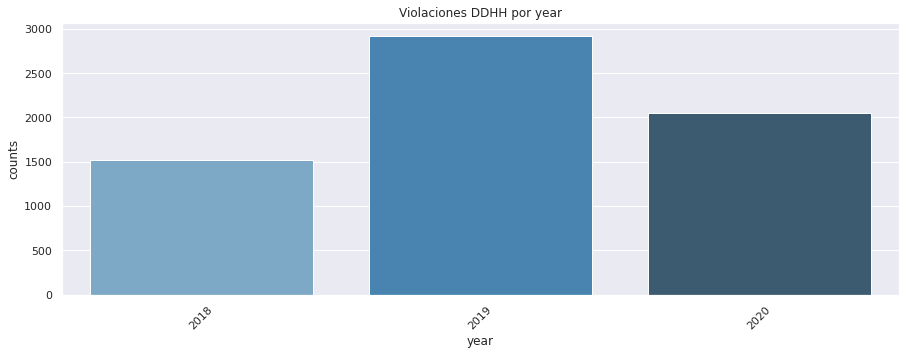

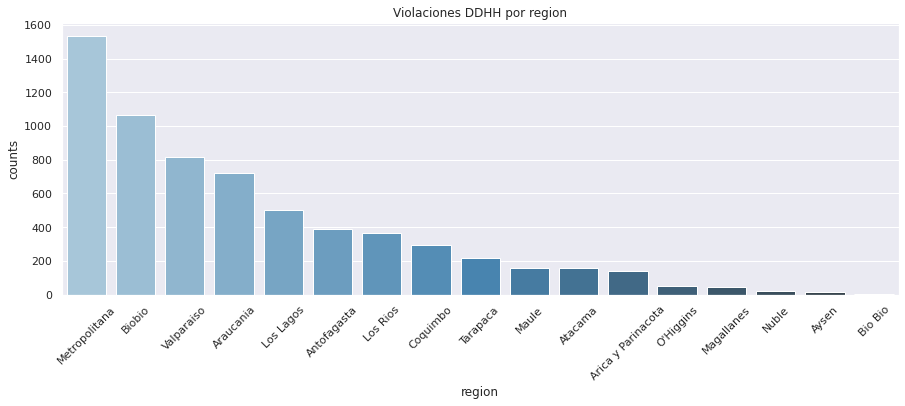

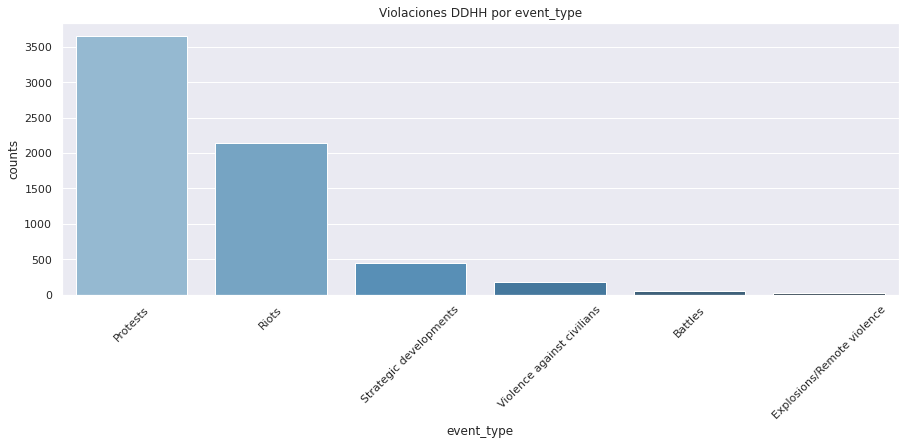

In [ ]:
see = ["year", "region", "event_type"]

for s in see:
  gr = data.groupby(s).size().nlargest(50).reset_index(name='counts')
  fig, ax = plt.subplots(figsize=(15, 5),nrows=1)
  sns.barplot(data=gr, x=s, y='counts', palette="Blues_d",ax=ax)
  ax.set_title('Violaciones DDHH por ' + s)
  ax.set_xticklabels(ax.get_xticklabels(), rotation=45)
  plt.show()
  print("")

cont_predictors_names = ['event_date', 'year', 'time_precision', 'sub_event_type',
       'actor1', 'assoc_actor_1', 'inter1', 'actor2', 'assoc_actor_2',
       'inter2', 'interaction', 'region', 'admin2', 'admin3',
       'latitude', 'longitude', 'geo_precision', 'source', 'source_scale',
       'notes', 'fatalities', 'timestamp']

classes = ["region", "event_type"]

### Split dataset

A predecir:

* Tipo de evento (event_type)
* Lugar (region)

LabelEncoder para encoding de atributos categóricos

In [ ]:
label_encoders = dict()
are_object = list()

for column in data.columns:
  if str(data[column].dtype) == "object":
      data[column] = data[column].astype('|S')
      are_object.append(column)

print("Son de tipo objeto:", len(are_object))

for is_object in are_object:
  label_encoders[is_object] = LabelEncoder()
  data[is_object] = label_encoders[is_object].fit_transform(data[is_object])

features = ['event_date', 'year', 'time_precision', 'sub_event_type',
       'actor1', 'assoc_actor_1', 'inter1', 'actor2', 'assoc_actor_2',
       'inter2', 'interaction', 'admin2', 'admin3', 'location',
       'latitude', 'longitude', 'geo_precision', 'source', 'source_scale',
       'notes', 'fatalities', 'timestamp']

predict = ["region", "event_type"]

X = data[features]
print("Cantidad de atributos:", X.shape[1])
Y = data[predict]

X_train_full, X_test, Y_train_full, Y_test = train_test_split(X, Y, test_size=0.5, random_state=0)
X_train, X_val, Y_train, Y_val = train_test_split(X_train_full, Y_train_full, test_size=0.5, random_state=0)

Son de tipo objeto: 14
Cantidad de atributos: 22


# Selección y regularización de atributos

In [ ]:
best_attributes = list()
worst_attributes = list()

## Ridge

Atributo: region


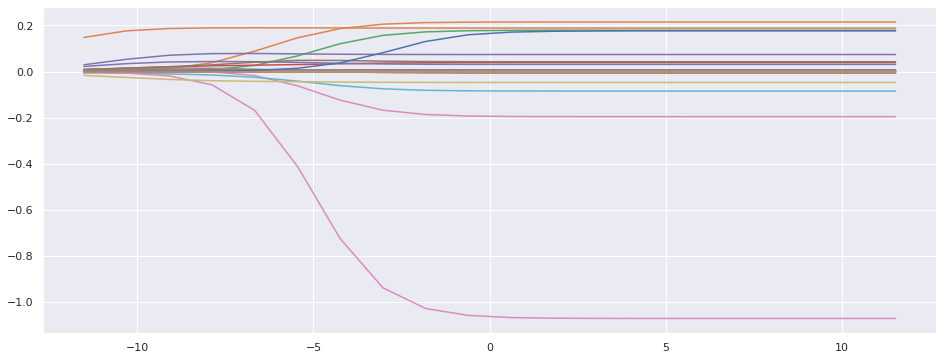

(22,)

Más Importantes:

['time_precision', 'assoc_actor_1', 'year', 'actor1', 'admin2']
['location', 'latitude', 'longitude', 'sub_event_type', 'source']

Menos Importantes:

['event_date', 'notes', 'source_scale', 'geo_precision', 'inter2']
['timestamp', 'admin3', 'assoc_actor_2', 'inter1', 'actor2']


Atributo: event_type


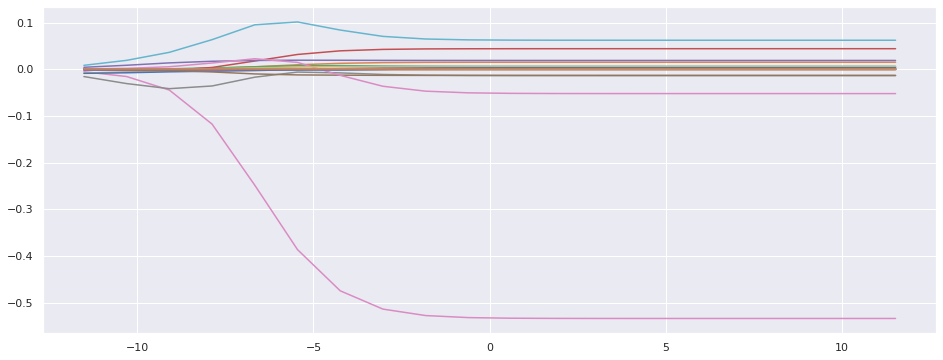

(22,)

Más Importantes:

['geo_precision', 'fatalities', 'latitude', 'interaction', 'sub_event_type']
['time_precision', 'source_scale', 'year', 'inter2', 'actor1']

Menos Importantes:

['event_date', 'notes', 'source', 'longitude', 'location']
['admin3', 'admin2', 'assoc_actor_2', 'timestamp', 'inter1']




In [ ]:
from sklearn.datasets import make_regression
from sklearn.linear_model import Ridge
from sklearn.metrics import mean_squared_error

for p in predict:
  print("Atributo:", p)
  
  alphas_ridge = list(np.logspace(-5, 5, num=20, base=10))
  active_ridge = []
  coef_matrix = []

  idx = 0
  coef_matrix = np.zeros((X_train.shape[1],len(alphas_ridge)))

  for alpha in alphas_ridge:
    modelo_ridge = Ridge(alpha)
    modelo_ridge.fit(X_train, Y_train[p])
    coefs_ridge = modelo_ridge.coef_
    active_ridge.append(len(coefs_ridge[coefs_ridge>0.001]))
    coef_matrix[:,idx] = coefs_ridge
    idx = idx + 1

  neg_log_alphas = -np.log(alphas_ridge)
  fig, ax = plt.subplots(figsize=(16,6),nrows=1, ncols=1)

  from_plot = 0
  for idx in range(X_train.shape[1]):
    sns.lineplot(x=neg_log_alphas[from_plot:],y=coef_matrix[idx,from_plot:],ax=ax)
  plt.show()

  importance = coef_matrix>0.001
  importance = np.sum(importance,axis=1)
  print(importance.shape)
  idx_imp = np.argsort(importance)
  top = idx_imp[-10:]
  names = X_train.columns
  names_top = [names[idx] for idx in top]

  bottom = idx_imp[:10]
  names_bottom = [names[idx] for idx in bottom]

  print("\nMás Importantes:\n")
  print(names_top[:5])
  print(names_top[5:])

  print("\nMenos Importantes:\n")
  print(names_bottom[:5])
  print(names_bottom[5:])

  print("\n")
  
  best_attributes.append(names_top[5:])
  best_attributes.append(names_top[:5])

  best_attributes.append(names_bottom[5:])
  best_attributes.append(names_bottom[:5])

## Correlación de Pearson

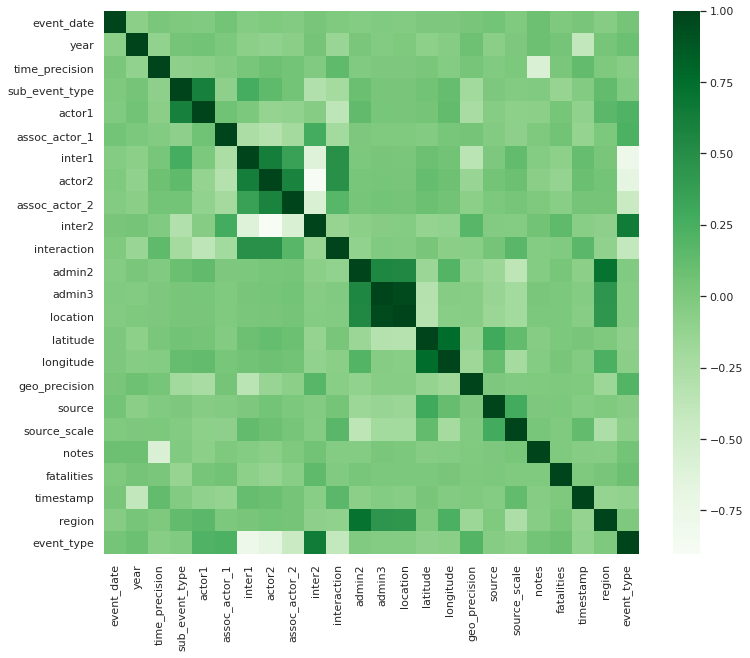

Correlación - Menos importantes:

                  region
time_precision  0.008243
event_type      0.008305
assoc_actor_1   0.009214
latitude        0.010647


Correlación - Más importantes:

            region
location  0.440301
admin3    0.442793
admin2    0.713222
region    1.000000



Correlación - Menos importantes:

                event_type
region            0.008305
admin2            0.020198
sub_event_type    0.023443
location          0.034009


Correlación - Más importantes:

            event_type
inter2        0.644077
actor2        0.672876
inter1        0.780674
event_type    1.000000





In [ ]:
plt.figure(figsize=(12,10))

corr_data = pd.concat([X_train, Y_train], axis=1)

cor = corr_data.corr()

sns.heatmap(cor, cmap=plt.cm.Greens)
plt.show()

for p in predict:
  cor_target = abs(cor[p])
  target_features = cor_target.sort_values().to_frame()
  
  print("Correlación - Menos importantes:\n")
  print(target_features[:4])
  print("\n")
  worst_attributes.append(target_features[p][:4].index.tolist())

  print("Correlación - Más importantes:\n")
  print(target_features[-4:])
  print("\n\n")
  
  best_attributes.append(target_features[p][-4:].index.tolist())
  

## Mutual info regression
## f regression

In [ ]:
print("Peores atributos\n")

for p in predict:
  print("Feature:", p)
  # mutual_info_regression
  selector = SelectKBest(mutual_info_regression, k=18)
  selector.fit(X_train, Y_train[p])

  cols = selector.get_support(indices=True)
  features_df_new = X_train.iloc[:,cols].columns
  worst_attr = set(list(features)) - set(list(features_df_new))
  print("Mutual regression info:", worst_attr)
  worst_attributes.append(list(worst_attr))

  # f_regression
  selector = SelectKBest(f_regression, k=18)
  selector.fit(X_train, Y_train[p])

  cols = selector.get_support(indices=True)
  features_df_new = X_train.iloc[:,cols].columns
  worst_attr = set(list(features)) - set(list(features_df_new))
  print("f regression:", worst_attr)
  worst_attributes.append(list(worst_attr))
  print("\n")

Peores atributos

Feature: region
Mutual regression info: {'year', 'fatalities', 'event_date', 'time_precision'}
f regression: {'source', 'assoc_actor_1', 'latitude', 'time_precision'}


Feature: event_type
Mutual regression info: {'year', 'timestamp', 'fatalities', 'time_precision'}
f regression: {'admin3', 'location', 'sub_event_type', 'admin2'}




## Mejores y peores atributos, cuenta final

In [ ]:
best = list()

for i in best_attributes:
  best += i

counter_best = Counter(best)

import heapq
from operator import itemgetter

n = 5

topitems = heapq.nlargest(n, counter_best.items(), key=itemgetter(1))  # Use .iteritems() on Py2
best = dict(topitems)

print("Best attributes:")
print(best)
print("\n")

worst = list()

for i in worst_attributes:
  worst += i

counter_worst = Counter(worst)

import heapq
from operator import itemgetter

n = 5

topitems = heapq.nlargest(n, counter_worst.items(), key=itemgetter(1))  # Use .iteritems() on Py2
worst = dict(topitems)

print("Worst attributes:")
print(worst)

Best attributes:
{'location': 3, 'admin2': 3, 'admin3': 3, 'inter1': 3, 'inter2': 3}


Worst attributes:
{'time_precision': 4, 'assoc_actor_1': 2, 'latitude': 2, 'admin2': 2, 'sub_event_type': 2}


> Se decide no sacar estos atributos, a menos que los algoritmos que se ocupen den malos resultados.

Distribuciones de los atributos

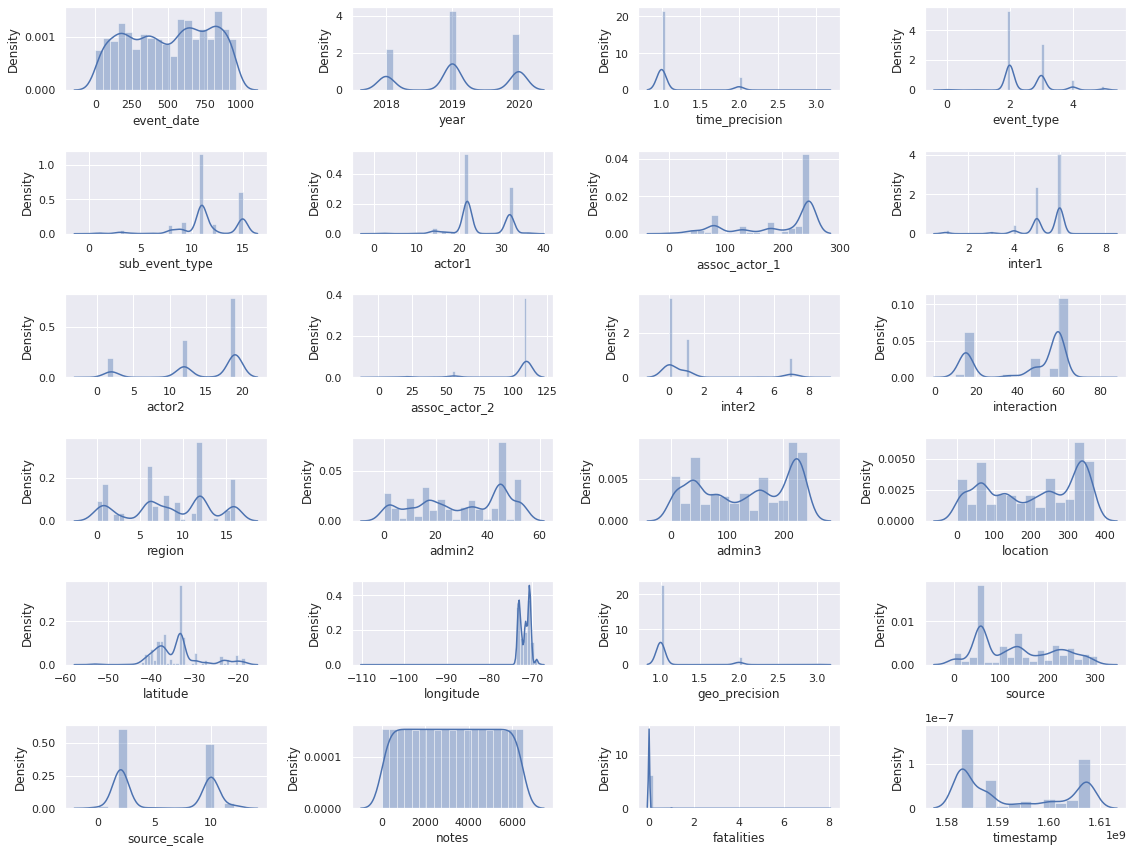

In [ ]:
fig, axes = plt.subplots(figsize=(16,12), nrows=6, ncols=4)
for i, column in enumerate(data.columns):
  sns.distplot(data[column], hist=True, rug=False, kde=True, ax=axes[i//4,i%4])

plt.tight_layout()
plt.show()

## Estandarización

In [ ]:
for c in X_train.columns:
  X_train[c] = scale(X_train[c])
  X_test[c] = scale(X_test[c])
  X_val[c] = scale(X_val[c])

for c in Y_train.columns:
  Y_train[c] = scale(Y_train[c])
  Y_test[c] = scale(Y_test[c])
  Y_val[c] = scale(Y_val[c])

## Distribuciones estandarizadas

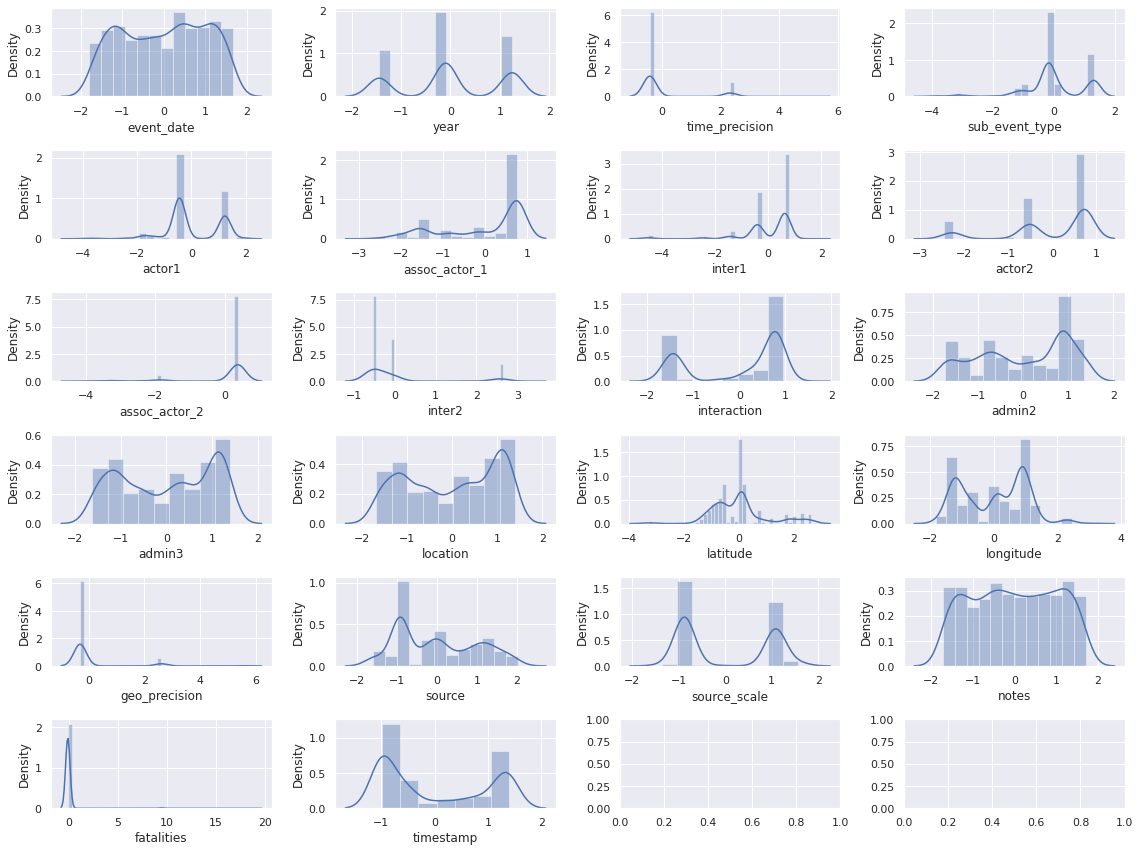

In [ ]:
fig, axes = plt.subplots(figsize=(16,12), nrows=6, ncols=4)
for i, column in enumerate(X_train.columns):
  sns.distplot(X_train[column], hist=True, rug=False, kde=True, ax=axes[i//4,i%4])

plt.tight_layout()
plt.show()

### Comprobar encoding

In [ ]:
print(data.dtypes)
print(X_train.shape)
print(X_val.shape)

event_date          int64
year                int64
time_precision      int64
event_type          int64
sub_event_type      int64
actor1              int64
assoc_actor_1       int64
inter1              int64
actor2              int64
assoc_actor_2       int64
inter2              int64
interaction         int64
region              int64
admin2              int64
admin3              int64
location            int64
latitude          float64
longitude         float64
geo_precision       int64
source              int64
source_scale        int64
notes               int64
fatalities          int64
timestamp           int64
dtype: object
(1623, 22)
(1623, 22)


# Modelos

* Red Neuronal Feed-Forward
* Random Forest
* AdaBoost

# Validación de los modelos: árbol de máxima profundidad

In [ ]:
tree = DecisionTreeRegressor(random_state=0)
print("Mejor árbol:")

tree.fit(X_train, Y_train)
print("Profundidad", tree.tree_.max_depth)
predictions = tree.predict(X_test)
print("MSE:", mean_squared_error(Y_test, predictions))

predictions = tree.predict(X_val)
print("MSE val:", mean_squared_error(Y_val, predictions))
print("\n")

for _ in range(2):
  tree = DecisionTreeRegressor(random_state=0, max_depth=tree.tree_.max_depth-1)
  print("Árbol podado:")

  tree.fit(X_train, Y_train)
  print("Profundidad", tree.tree_.max_depth)
  predictions = tree.predict(X_test)
  print("MSE:", mean_squared_error(Y_test, predictions))

  predictions = tree.predict(X_val)
  print("MSE val:", mean_squared_error(Y_val, predictions))
  print("\n")

Mejor árbol:
Profundidad 13
MSE: 0.21475772575131707
MSE val: 0.3411176547740605


Árbol podado:
Profundidad 12
MSE: 0.2118410693359366
MSE val: 0.3358800686622634


Árbol podado:
Profundidad 11
MSE: 0.18749730610617632
MSE val: 0.3121105895549603




## Red Neuronal Feed-Forward


In [ ]:
def create_model(optimizer='rmsprop', nneuron=24, n_outputs=2):
  
    model = Sequential()
    model.add(Dense(nneuron, input_shape=(X_train.shape[1],), kernel_initializer='normal', activation='relu'))
    model.add(Dense(int(nneuron*1.5), kernel_initializer='normal', activation='relu'))
    model.add(Dense(n_outputs, activation="linear", kernel_initializer='normal'))

    if optimizer == "rmsprop":
      opt = RMSprop()
    elif optimizer == "adam":
      opt = Adam()
    elif optimizer == "SGD":
      opt = SGD()
    else:
      return "error"

    model.compile(
        loss='mse',
        metrics=[tf.keras.metrics.RootMeanSquaredError(),
                 tf.keras.metrics.MeanAbsolutePercentageError(),
                 ],
        optimizer=opt)
    
    return model

model = KerasRegressor(build_fn=create_model, epochs=20, batch_size=5, verbose=0)

optimizers = ['SGD', 'rmsprop', 'adam']
epochs = [10, 50]
batches = [5, 10]
nneurons = [22]

param_grid = dict(optimizer=optimizers, epochs=epochs, batch_size=batches, nneuron=nneurons)
grid = GridSearchCV(estimator=model, param_grid=param_grid, cv=10)
grid_result = grid.fit(X_train, Y_train)

print("Best: %f con %s" % (grid_result.best_score_, grid_result.best_params_))

means = grid_result.cv_results_['mean_test_score']
stds = grid_result.cv_results_['std_test_score']
params = grid_result.cv_results_['params']

for mean, stdev, param in zip(means, stds, params):
	print("%f (%f) con: %r" % (mean, stdev, param))

Best: -0.132558 con {'batch_size': 5, 'epochs': 50, 'nneuron': 22, 'optimizer': 'adam'}
-0.258635 (0.058441) con: {'batch_size': 5, 'epochs': 10, 'nneuron': 22, 'optimizer': 'SGD'}
-0.236137 (0.057907) con: {'batch_size': 5, 'epochs': 10, 'nneuron': 22, 'optimizer': 'rmsprop'}
-0.208659 (0.050768) con: {'batch_size': 5, 'epochs': 10, 'nneuron': 22, 'optimizer': 'adam'}
-0.155218 (0.047483) con: {'batch_size': 5, 'epochs': 50, 'nneuron': 22, 'optimizer': 'SGD'}
-0.153929 (0.047069) con: {'batch_size': 5, 'epochs': 50, 'nneuron': 22, 'optimizer': 'rmsprop'}
-0.132558 (0.045452) con: {'batch_size': 5, 'epochs': 50, 'nneuron': 22, 'optimizer': 'adam'}
-0.342351 (0.076159) con: {'batch_size': 10, 'epochs': 10, 'nneuron': 22, 'optimizer': 'SGD'}
-0.246143 (0.062698) con: {'batch_size': 10, 'epochs': 10, 'nneuron': 22, 'optimizer': 'rmsprop'}
-0.229137 (0.060226) con: {'batch_size': 10, 'epochs': 10, 'nneuron': 22, 'optimizer': 'adam'}
-0.193586 (0.049979) con: {'batch_size': 10, 'epochs': 50

# Mejor red neuronal

In [ ]:
optimizer = grid_result.best_params_["optimizer"]
nneuron = grid_result.best_params_["nneuron"]
batch_size = grid_result.best_params_["batch_size"]
epochs = grid_result.best_params_["epochs"] * 10

model = create_model(optimizer=optimizer, nneuron=nneuron)
history = model.fit(X_train, Y_train, batch_size=batch_size, epochs=epochs, verbose=1, validation_data=(X_val, Y_val))

Epoch 1/500
325/325 [==============================] - 1s 3ms/step - loss: 0.8032 - root_mean_squared_error: 0.8930 - mean_absolute_percentage_error: 85.2550 - val_loss: 0.3651 - val_root_mean_squared_error: 0.6042 - val_mean_absolute_percentage_error: 54.9486
Epoch 2/500
325/325 [==============================] - 1s 2ms/step - loss: 0.3250 - root_mean_squared_error: 0.5690 - mean_absolute_percentage_error: 50.8466 - val_loss: 0.3044 - val_root_mean_squared_error: 0.5517 - val_mean_absolute_percentage_error: 51.4135
Epoch 3/500
325/325 [==============================] - 1s 2ms/step - loss: 0.3050 - root_mean_squared_error: 0.5495 - mean_absolute_percentage_error: 50.6542 - val_loss: 0.2796 - val_root_mean_squared_error: 0.5287 - val_mean_absolute_percentage_error: 49.1650
Epoch 4/500
325/325 [==============================] - 1s 2ms/step - loss: 0.2439 - root_mean_squared_error: 0.4936 - mean_absolute_percentage_error: 45.5888 - val_loss: 0.2629 - val_root_mean_squared_error: 0.5127 - 

## Gráfico performance

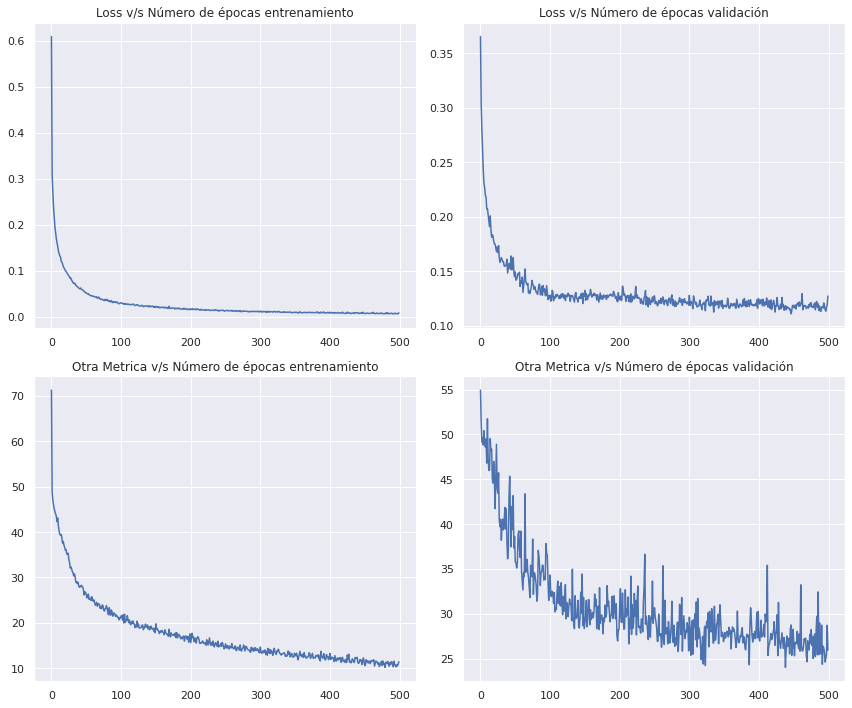

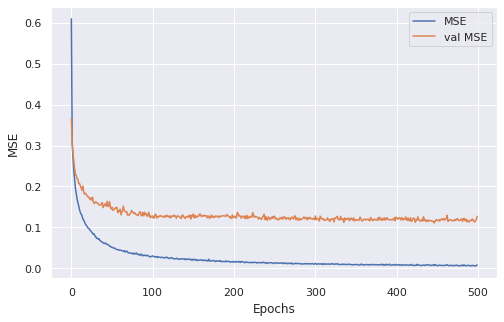

In [ ]:
fig, axis = plt.subplots(2, 2, figsize=(12,10))
axis[0,0].plot(history.history['loss'], label='mse')
axis[0,1].plot(history.history['val_loss'], label='val_mse')
axis[1,0].plot(history.history['mean_absolute_percentage_error'], label='mse')#root_mean_squared_error
axis[1,1].plot(history.history['val_mean_absolute_percentage_error'], label='val_mse')
axis[0,0].set_title("Loss v/s Número de épocas entrenamiento")
axis[0,1].set_title("Loss v/s Número de épocas validación")
axis[1,0].set_title("Otra Metrica v/s Número de épocas entrenamiento")
axis[1,1].set_title("Otra Metrica v/s Número de épocas validación")
plt.tight_layout()
plt.show()

fig, axis = plt.subplots(figsize=(8,5))

plt.plot(history.history['loss'], label='mse')
plt.plot(history.history['val_loss'], label='val_mse')
plt.xlabel("Epochs")
plt.ylabel("MSE")
plt.legend(['MSE', 'val MSE']);
plt.show()

## Random Forest

In [ ]:
from sklearn import tree, ensemble
from imblearn.under_sampling import RandomUnderSampler
from imblearn.pipeline import make_pipeline
from sklearn.multioutput import MultiOutputRegressor
from sklearn.metrics import mean_squared_error

def RF_model(X, y):
  gsc = GridSearchCV(
      estimator=ensemble.RandomForestRegressor(),
      param_grid={
          'max_depth': range(3, 10),
          'n_estimators': range(10),
          'random_state': [0]
      },
      cv=10,
      scoring='neg_mean_squared_error',
      verbose=0,
      n_jobs=-1)

  grid_result = gsc.fit(X_train, Y_train)
  best_params = grid_result.best_params_

  return best_params

best_params = RF_model(X_train, Y_train)
print("Mejores parámetros (Random Forest):", best_params)

forest = ensemble.RandomForestRegressor(max_depth=best_params["max_depth"], n_estimators=best_params["n_estimators"], random_state=best_params["random_state"])
forest.fit(X_train, Y_train)

predictions = forest.predict(X_test)
print("MSE:", mean_squared_error(Y_test, predictions))

predictions = forest.predict(X_val)
print("MSE val:", mean_squared_error(Y_val, predictions))

Mejores parámetros (Random Forest): {'max_depth': 9, 'n_estimators': 8, 'random_state': 0}
MSE: 0.07748437133261832
MSE val: 0.2454538183036876


## AdaBoost

In [ ]:
def Ada_model(X, y):
  AB = ensemble.AdaBoostRegressor()
  gsc = GridSearchCV(
      estimator=MultiOutputRegressor(AB),
      param_grid={
          'estimator__base_estimator': [DecisionTreeRegressor(max_depth=x) for x in range(3, 10)],
          'estimator__n_estimators': range(50),
          'estimator__random_state': [0]
      },
      cv=10,
      scoring='neg_mean_squared_error',
      verbose=0,
      n_jobs=-1)

  grid_result = gsc.fit(X_train, Y_train)
  best_params = grid_result.best_params_

  return best_params

best_params = Ada_model(X_train, Y_train)

ada_boost = MultiOutputRegressor(
    ensemble.AdaBoostRegressor(base_estimator=best_params["estimator__base_estimator"],
    n_estimators=best_params["estimator__n_estimators"],
    random_state=best_params["estimator__random_state"]
    ))

print("Mejores parámetros (Ada Boost):", best_params)
base_estimator = best_params["estimator__base_estimator"]
n_estimators = best_params["estimator__n_estimators"]
random_state = best_params["estimator__random_state"]

ada_boost.fit(X_train, Y_train)

predictions = ada_boost.predict(X_test)
print("MSE:", mean_squared_error(Y_test, predictions))

predictions = ada_boost.predict(X_val)
print("MSE val:", mean_squared_error(Y_val, predictions))

Mejores parámetros (Ada Boost): {'estimator__base_estimator': DecisionTreeRegressor(ccp_alpha=0.0, criterion='mse', max_depth=7,
                      max_features=None, max_leaf_nodes=None,
                      min_impurity_decrease=0.0, min_impurity_split=None,
                      min_samples_leaf=1, min_samples_split=2,
                      min_weight_fraction_leaf=0.0, presort='deprecated',
                      random_state=None, splitter='best'), 'estimator__n_estimators': 28, 'estimator__random_state': 0}
MSE: 0.02508436465444803
MSE val: 0.033058848477765385


## Referencias

* Feature Scaling for Machine Learning: Understanding the Difference Between Normalization vs. Standardization: https://www.analyticsvidhya.com/blog/2020/04/feature-scaling-machine-learning-normalization-standardization/
* How to create a random split cross validation and bagging emsemble for deep learning in keras: https://machinelearningmastery.com/how-to-create-a-random-split-cross-validation-and-bagging-ensemble-for-deep-learning-in-keras/
* Adaboost ensemble in Python: https://machinelearningmastery.com/adaboost-ensemble-in-python/
* Notebook ejercicios Tema 12 - Profesor Ricardo Ñanculef